In [4]:
! pip install -U mlxtend
! pip install -U statsmodels
! pip install -U scikit-learn

     |████████████████████████████████| 1.3 MB 5.0 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


     |████████████████████████████████| 9.8 MB 5.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
import warnings
warnings.filterwarnings('ignore')

# set terminal options to display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/652 final project'

os.chdir(path)
os.listdir(path)

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import pylab as pl
from sklearn.metrics import roc_curve, auc, r2_score
from sklearn import datasets
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from itertools import cycle
from tqdm.auto import tqdm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 100)

data = pd.read_csv('raw_data.csv', header = 0)
data.head()

ImportError: ignored

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, r2_score

In [43]:
columns = ['Age','GS/G','MP/G','FGP','3PP','2PP','eFGP','FTP','TRB/G','AST/G','STL/G','BLK/G','TOV/G','PF/G','PTS/G','CSS']
columns_drop = ['Pos','Rk','Player','G','Tm','GS','MP','FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS','NSS']
data = data.drop(columns_drop, axis = 1)

In [ ]:
#data.describe().T.to_excel('data_describe.xlsx')

缺失值处理

In [ ]:
# 统计缺失值数量
missing=data.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/data.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
# miss_analy 存储的是每个变量缺失情况的数据框

fig = plt.figure(figsize=(18,8))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align = 'center'
    ,color=['red','green','yellow','steelblue'])

plt.title('Histogram of missing value of variables')
plt.xlabel('variables names')
plt.ylabel('missing rate')
# 添加x轴标签，并旋转90度
plt.xticks(np.arange(miss_analy.shape[0]),list(miss_analy['index']))
pl.xticks(rotation=0)
# 添加数值显示
for x,y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x,y+0.02,'{:.2%}'.format(y),ha='center',rotation=0)    
plt.ylim([0,0.1])
plt.savefig('Missing value of variables')    
plt.show()

In [ ]:
#删除缺失30%以上的行/列
data.dropna(thresh = int(data.shape[0]*0.7), axis = 1, inplace = True)
data.dropna(thresh = int(data.shape[1]*0.7), axis = 0, inplace = True)
#删除重复的列/行
data.drop_duplicates() 


In [46]:
#用前一个非缺失值去填充该缺失值
dl = data.columns.tolist()
for col in range(data.shape[1]):
    if data[dl[col]].dtypes != 'object':
        data[dl[col]].fillna(data[dl[col]].mean(), inplace = True)
    else:
        data[dl[col]].fillna(method = 'pad', inplace = True)

In [47]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

y = data['CSS'].div(100000)
x = data.drop('CSS', axis = 1)
x = sm.add_constant(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [48]:
x_train.describe()

,const,Age,GS/G,MP/G,FGP,3PP,2PP,eFGP,FTP,TRB/G,AST/G,STL/G,BLK/G,TOV/G,PF/G,PTS/G
count,1224.0,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000
mean,1.0,25.651961,0.373391,19.698435,0.446764,0.312315,0.508599,0.509947,0.747279,3.624230,1.965574,0.626990,0.393485,1.100744,1.713762,8.822165
std,0.0,4.110467,0.397954,9.153538,0.106859,0.129046,0.114860,0.108559,0.138344,2.459418,1.803931,0.405907,0.401269,0.820927,0.791536,6.352007
min,1.0,19.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,22.000000,0.016000,12.635250,0.403000,0.281000,0.464000,0.478750,0.691000,1.877000,0.750000,0.333000,0.132750,0.542500,1.158000,4.195500
50%,1.0,25.000000,0.183000,19.321500,0.444000,0.333000,0.510500,0.519000,0.763000,3.127500,1.367500,0.567000,0.274000,0.881500,1.716500,7.197500
75%,1.0,28.000000,0.814250,27.471500,0.493000,0.377000,0.564000,0.559000,0.832000,4.717000,2.544500,0.866250,0.520500,1.441750,2.244250,11.917750
max,1.0,42.000000,1.000000,37.485000,1.000000,1.000000,1.000000,1.500000,1.000000,15.595000,10.740000,2.208000,3.383000,5.000000,5.000000,36.128000


In [63]:
y_train.describe().to_csv('y_train describe.csv')

In [ ]:
# 'Age','GS/G','MP/G','FGP','3PP','2PP','eFGP','FTP','TRB/G','AST/G','STL/G','BLK/G','TOV/G','PF/G','PTS/G','CSS'要畫直方圖

Text(0.5, 1.0, 'Age Distribution')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Count')

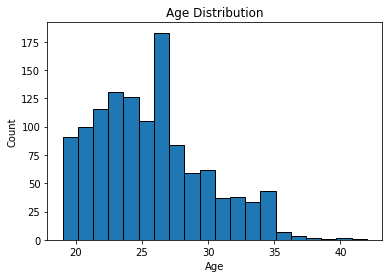

In [50]:
#draw pictue of other variables
x_train['Age'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
#plt.grid(axis='y', alpha=0.75)
plt.savefig('Age')

Text(0.5, 1.0, 'GS/G Distribution')

Text(0.5, 0, 'GSG')

Text(0, 0.5, 'Count')

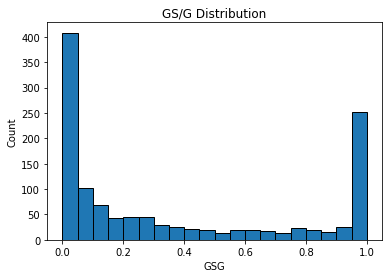

In [14]:
x_train['GS/G'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('GS/G Distribution')
plt.xlabel('GSG')
plt.ylabel('Count')
plt.savefig('GSG')

Text(0.5, 1.0, 'MP/G Distribution')

Text(0.5, 0, 'MPG')

Text(0, 0.5, 'Count')

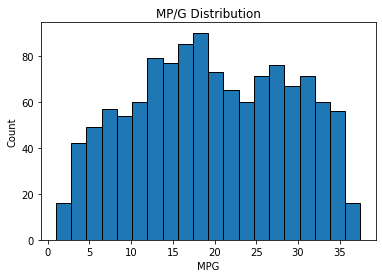

In [15]:
x_train['MP/G'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('MP/G Distribution')
plt.xlabel('MPG')
plt.ylabel('Count')
plt.savefig('MPG')

Text(0.5, 1.0, 'FGP Distribution')

Text(0.5, 0, 'FGP')

Text(0, 0.5, 'Count')

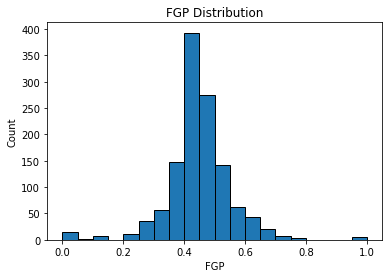

In [16]:
x_train['FGP'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('FGP Distribution')
plt.xlabel('FGP')
plt.ylabel('Count')
plt.savefig('FGP')

Text(0.5, 1.0, '3PP Distribution')

Text(0.5, 0, '3PP')

Text(0, 0.5, 'Count')

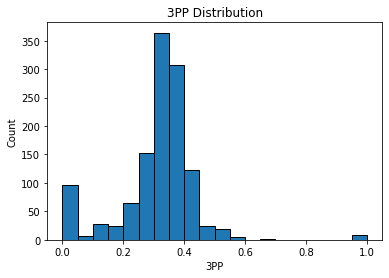

In [17]:
x_train['3PP'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('3PP Distribution')
plt.xlabel('3PP')
plt.ylabel('Count')
plt.savefig('3PP')

Text(0.5, 1.0, '2PP Distribution')

Text(0.5, 0, '2PP')

Text(0, 0.5, 'Count')

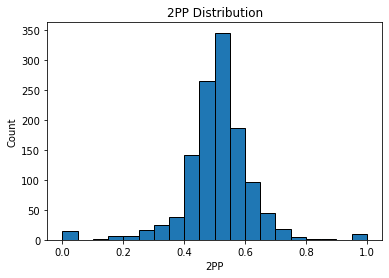

In [18]:
x_train['2PP'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('2PP Distribution')
plt.xlabel('2PP')
plt.ylabel('Count')
plt.savefig('2PP')

Text(0.5, 1.0, 'eFGP Distribution')

Text(0.5, 0, 'eFGP')

Text(0, 0.5, 'Count')

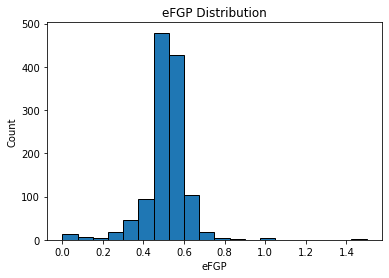

In [19]:
x_train['eFGP'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('eFGP Distribution')
plt.xlabel('eFGP')
plt.ylabel('Count')
plt.savefig('eFGP')

Text(0.5, 1.0, 'FTP Distribution')

Text(0.5, 0, 'FTP')

Text(0, 0.5, 'Count')

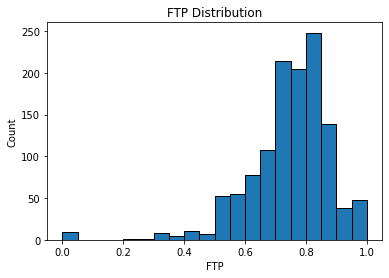

In [20]:
x_train['FTP'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('FTP Distribution')
plt.xlabel('FTP')
plt.ylabel('Count')
plt.savefig('FTP')

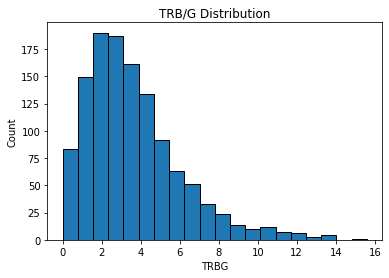

In [21]:
x_train['TRB/G'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('TRB/G Distribution')
plt.xlabel('TRBG')
plt.ylabel('Count')
plt.savefig('TRBG')

Text(0.5, 1.0, 'AST/G Distribution')

Text(0.5, 0, 'ASTG')

Text(0, 0.5, 'Count')

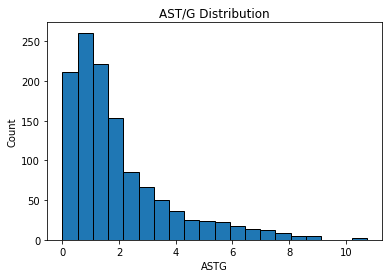

In [22]:
x_train['AST/G'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('AST/G Distribution')
plt.xlabel('ASTG')
plt.ylabel('Count')
plt.savefig('ASTG')

Text(0.5, 1.0, 'STL/G Distribution')

Text(0.5, 0, 'STLG')

Text(0, 0.5, 'Count')

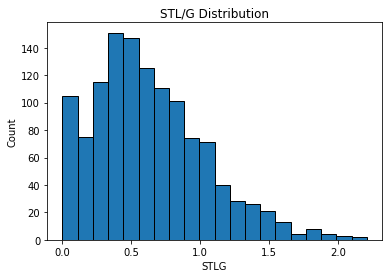

In [23]:
x_train['STL/G'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('STL/G Distribution')
plt.xlabel('STLG')
plt.ylabel('Count')
plt.savefig('STLG')

Text(0.5, 1.0, 'BLK/G Distribution')

Text(0.5, 0, 'BLKG')

Text(0, 0.5, 'Count')

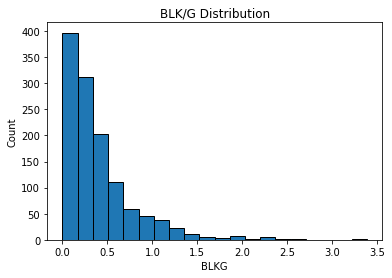

In [24]:
x_train['BLK/G'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('BLK/G Distribution')
plt.xlabel('BLKG')
plt.ylabel('Count')
plt.savefig('BLKG')

Text(0.5, 1.0, 'TOV/G Distribution')

Text(0.5, 0, 'TOVG')

Text(0, 0.5, 'Count')

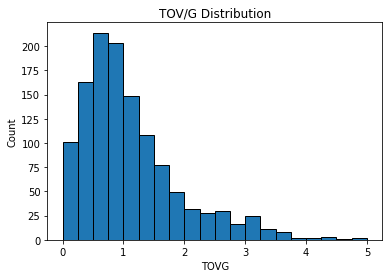

In [25]:
x_train['TOV/G'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('TOV/G Distribution')
plt.xlabel('TOVG')
plt.ylabel('Count')
plt.savefig('TOVG')

Text(0.5, 1.0, 'PF/G Distribution')

Text(0.5, 0, 'PFG')

Text(0, 0.5, 'Count')

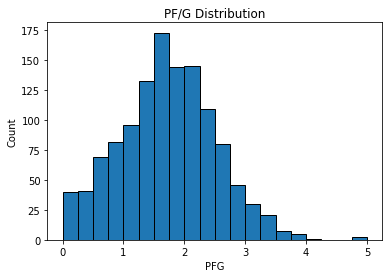

In [26]:
x_train['PF/G'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('PF/G Distribution')
plt.xlabel('PFG')
plt.ylabel('Count')
plt.savefig('PFG')

Text(0.5, 1.0, 'PTS/G Distribution')

Text(0.5, 0, 'PTSG')

Text(0, 0.5, 'Count')

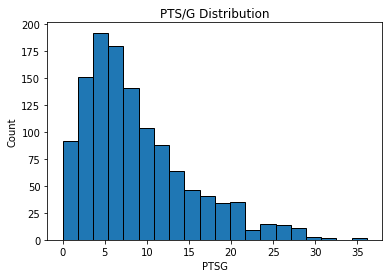

In [27]:
x_train['PTS/G'].plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('PTS/G Distribution')
plt.xlabel('PTSG')
plt.ylabel('Count')
plt.savefig('PTSG')

Text(0.5, 1.0, 'CSS Distribution')

Text(0.5, 0, 'CSS(in million)')

Text(0, 0.5, 'Count')

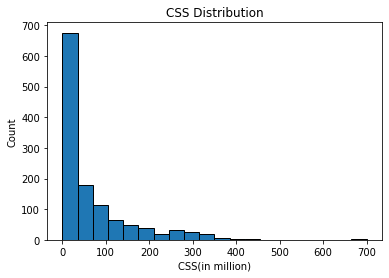

In [64]:
y_train.plot.hist(bins=20, rwidth=1, edgecolor='black')
plt.title('CSS Distribution')
plt.xlabel('CSS(in million)')
plt.ylabel('Count')
plt.savefig('CSS')

Text(0.5, 1.0, 'Heatmap of correlation between x-train variables')

Text(0.5, 60.0, 'variables names')

Text(79.80000000000004, 0.5, 'variables names')

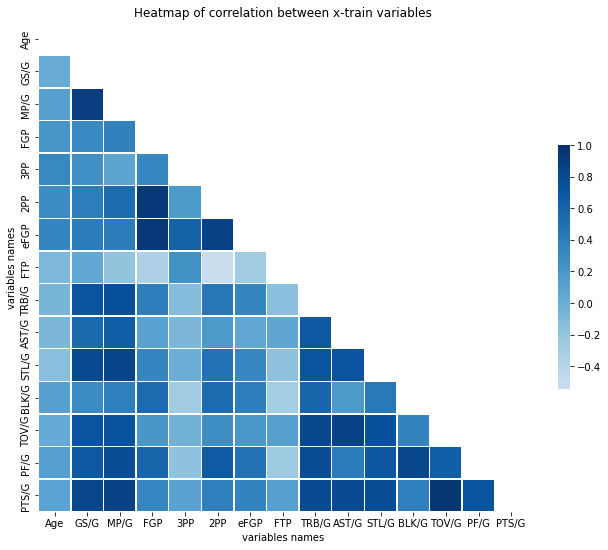

In [52]:


# correlation matrix
corr = x_train.iloc[1:17, 1:17].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True) 
cmap = "Blues"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap of correlation between x-train variables')
plt.xlabel('variables names')
plt.ylabel('variables names')

plt.savefig('Correlation between x variables') 
plt.show()


In [ ]:
def checkVIF_new(df):
    name = df.columns
    x = np.matrix(df)
    VIF_list = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
    VIF = pd.DataFrame({'feature':name,"VIF":VIF_list})
    max_VIF = max(VIF_list)
    print(max_VIF)
    return VIF
  
checkVIF_new(x_train)

with open('full_model VIF.csv', 'w') as ot:
    ot.write(checkVIF_new(x_train).to_csv())

In [ ]:
#y,x的full model回归
full_model = sm.OLS(y_train, x_train).fit()
full_model.summary()

with open('full_model summary.csv', 'w') as ot:
    ot.write(full_model.summary().as_csv())

In [ ]:
x_train.drop(['eFGP','MP/G','FGP','const'], axis = 1, inplace=True)

full_model_s = LinearRegression()
full_model_s.fit(x_train, y_train)
full_model_s.coef_

In [57]:
r_score = []

In [ ]:
model_sfs = SFS(full_model_s, scoring='neg_mean_squared_error', k_features=12, verbose=1, cv=5)
model_sfs.fit(x_train, y_train)
model_sfs.get_metric_dict()
pd.DataFrame.from_dict(model_sfs.get_metric_dict()).T.to_excel('x_selection.xlsx')
X_selected = model_sfs.transform(x_train)
model_after_selection = full_model_s.fit(X_selected, y_train)
y_pred = model_after_selection.predict(X_selected)
r_score.append(r2_score(y_train, y_pred))


Selected feature:
'Age',
   'GS/G',
   '3PP',
   '2PP',
   'FTP',
   'TRB/G',
   'AST/G',
   'BLK/G',
   'PF/G',
   'PTS/G'

In [59]:
r_score

[0.5926020886606584]

In [ ]:
adj_r_score = []
for p in range(12):
  adj_r_score.append(1-(1-r_score[p])*(1223)/(1223-(p+1)))

In [ ]:
adj_r_score

In [60]:
x_train = sm.add_constant(x_train)
model_s = sm.OLS((y_train),x_train[['const','Age', 'GS/G', '3PP', '2PP', 'FTP', 'TRB/G', 'AST/G', 'BLK/G', 'PF/G', 'PTS/G']]).fit()
model_s.summary()

with open('selected_model summary.csv', 'w') as ot:
    ot.write(model_s.summary().as_csv())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CSS   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     170.8
Date:                Sun, 12 Dec 2021   Prob (F-statistic):          2.15e-223
Time:                        05:41:24   Log-Likelihood:                -6663.7
No. Observations:                1224   AIC:                         1.335e+04
Df Residuals:                    1213   BIC:                         1.341e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -142.9838     15.636     -9.145      0.000    -173.660    -112.308
Age            6.3381      0.401     15.815      0.000       5.552       7.124
GS/G          37.5851      6.732      5.583      0.000      24.377      50.794
3PP          -24.3560     13.433     -1.813      0.070     -50.711       1.999
2PP          -17.0765     15.043     -1.135      0.257     -46.590      12.437
FTP           -0.2029     12.959     -0.016      0.988     -25.627      25.221
TRB/G          6.7311      1.207      5.577      0.000       4.363       9.099
AST/G          7.8466      1.390      5.647      0.000       5.120      10.573
BLK/G         10.7819      5.840      1.846      0.065      -0.676      22.240
PF/G         -22.5817      3.143     -7.186      0.000     -28.747     -16.416
PTS/G          5.0586      0.510      9.924      0.000       4.059       6.059
==============================================================================
Omnibus:                      504.897   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8177.037
Skew:                           1.471   Prob(JB):                         0.00
Kurtosis:                      15.316   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1753

In [ ]:
y_pred = model_s.predict(x_test[['const','Age', 'GS/G', '3PP', '2PP', 'FTP', 'TRB/G', 'AST/G', 'BLK/G', 'PF/G', 'PTS/G']])
y_test.reset_index(drop = True, inplace = True)
y_pred.reset_index(drop = True, inplace = True)

In [ ]:
plt.figure(figsize= (65,10))
plt.plot(y_pred,color='blue',linewidth = 5,
         label='y_pred')
plt.plot(y_test,color='red',linewidth = 5,
         label='y_test')
plt.xlabel('Player ID',fontsize = 40)
plt.ylabel('Current Season Salary',fontsize = 40)

plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
plt.legend(fontsize = 40)
plt.savefig('y_pred vs y_test') 
plt.show()

In [ ]:
y_test

In [ ]:
metrics.mean_squared_error(y_true=y_test, y_pred=y_pred)

28441884835979.06

outliner 处理

In [ ]:
#画出每个numerical column的箱线图
dl = data.columns.tolist()
for col in range(data.shape[1]):
    if data[dl[col]].dtypes != 'object':
        fig,axes = plt.subplots() 
        data[[dl[col]]].boxplot()
        #fig.savefig(dl[col] + ' before')

In [ ]:
#处理离群值，以上界填充极大值，以下界填充最小值，画出每个经过处理后numerical column的箱线图
def boxplot_fill(col):
    iqr = col.quantile(0.75) - col.quantile(0.25)
    u_th = col.quantile(0.75) + 1.5*iqr #上界
    l_th = col.quantile(0.25) - 1.5*iqr #下界
    
    def box_trans(x):
        if x > u_th:
            return u_th
        elif x < l_th:
            return l_th
        else:
            return x
    return col.map(box_trans)

dl = data.columns.tolist()
for col in range(data.shape[1]):
    if data[dl[col]].dtype != 'object':
        fig,axes = plt.subplots() 
        data[dl[col]] = boxplot_fill(data[dl[col]])
        data[[dl[col]]].boxplot()
        #fig.savefig(dl[col] + ' after')

In [ ]:
data.describe().T.to_excel('data_describe.xlsx')

In [ ]:
data.to_csv('preprocessed_data.csv')